In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (recall_score, 
                            confusion_matrix, ConfusionMatrixDisplay,
                            precision_score, roc_auc_score, 
                            roc_curve, precision_recall_curve, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik import phik_matrix

## Шаг 1. Загрузка данных

In [81]:
train_data = pd.read_csv('heart_train.csv')

In [82]:
train_data

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,...,0.0,0.166667,0.0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734
8681,8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,...,6.0,0.833333,0.0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191
8682,8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,...,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390
8683,8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,...,4.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860


In [83]:
train_data = train_data.drop('Unnamed: 0', axis=1)

In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

8685 строк в полных столбцах. Есть пропуски в 15-ти столбцах, в каждом 243 строк пропуска

In [85]:
test_data = pd.read_csv('heart_test.csv')

In [86]:
test_data

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,961,0.640449,0.235714,0.064161,1.0,0.0,1.0,0.0,1.0,0.449213,...,0.283117,5.0,0.000000,0.110672,0.049750,0.000777,Male,0.425806,0.744186,9271
962,962,0.516854,0.367857,0.063245,1.0,0.0,1.0,0.0,0.0,0.563595,...,0.422078,2.0,0.000000,0.114625,0.008706,0.001456,Male,0.651613,0.697674,8012
963,963,0.213483,0.596429,0.076994,1.0,0.0,1.0,1.0,1.0,0.549976,...,0.914286,4.0,0.666667,0.227018,0.048229,0.036512,Male,0.696774,0.767442,2456
964,964,0.337079,0.996429,0.036664,1.0,0.0,1.0,0.0,0.0,0.441581,...,0.850649,2.0,0.500000,0.132411,0.006904,0.000485,Male,0.348387,0.627907,4984


In [87]:
test_data = test_data.drop('Unnamed: 0', axis=1)

In [88]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level          

966 строк в столбцах без пропусков. Пропуски в одних и тех же колонках: Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week

## Шаг 2. Предобработка данных

Целевой признак - **'Heart Attack Risk (Binary)'**

In [89]:
train_data[ 'Heart Attack Risk (Binary)'].value_counts()

Heart Attack Risk (Binary)
0.0    5672
1.0    3013
Name: count, dtype: int64

In [90]:
#приведем к типу int8
train_data[ 'Heart Attack Risk (Binary)'] = train_data[ 'Heart Attack Risk (Binary)'].astype('int8')

Категорийный признак - **Gender**

In [91]:
train_data['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

In [92]:
def magic(df):
    return (df['Gender'].astype(str).str.lower().replace({
        'male':1,
        'female':0,
        '1.0':1,
        '0.0':0
}).infer_objects(copy=False).astype('int8'))

In [93]:
train_data['Gender'] = magic(train_data)
test_data['Gender'] = magic(test_data)

C:\Users\User\AppData\Local\Temp\ipykernel_12728\2951076920.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return (df['Gender'].astype(str).str.lower().replace({
C:\Users\User\AppData\Local\Temp\ipykernel_12728\2951076920.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return (df['Gender'].astype(str).str.lower().replace({


**Дупликаты**

In [94]:
train_data.duplicated().sum()

np.int64(0)

In [95]:
test_data.duplicated().sum()

np.int64(0)

**Заполнение прокусков**

In [96]:
cols = ['Diabetes', 'Family History', 'Smoking','Obesity', 'Alcohol Consumption','Previous Heart Problems',
       'Medication Use','Stress Level','Physical Activity Days Per Week']

for col in cols:
    #заполнил модом и привел к типу int
    mode_val = train_data[col].mode()[0]
    train_data[col] = train_data[col].fillna(mode_val).astype('int8')
    test_data[col] = test_data[col].fillna(mode_val).astype('int8')

## Шаг 3. Исследовательский анализ данных

In [97]:
def numerical(series,text):
    display(series.describe())
    
    fig,axs=plt.subplots(1,2,figsize=(12,5))
    
    #boxplot
    sns.boxplot(y=series,ax=axs[0], color='lightgreen')
    axs[0].set_title(f'Boxplot для {text}')
    
    #hist
    sns.histplot(series,ax=axs[1], bins=20, kde=True, color='skyblue')
    axs[1].set_title(f'Распределения для колонки {text}')
    axs[1].set_ylabel('Количество')
    axs[1].set_xlabel(text)
        
    plt.tight_layout()
    plt.show()

In [98]:
def discrete(series,text):
    display(series.describe())
    
    fig,axs=plt.subplots(1,2,figsize=(12,5))
    
    #boxplot
    sns.boxplot(y=series,ax=axs[0], color='lightgreen')
    axs[0].set_title(f'Boxplot для {text}')
    
    
    #barplot
    counts = series.value_counts()
    sns.barplot(x=counts.index.astype(str),y=counts.values,ax=axs[1])
    
    for index,value in enumerate(counts):
        plt.text(index,value,str(value),ha='center')
    
    plt.ylabel('Количество')
    plt.xlabel(text)
    plt.title(f'Распределение по колонке {text}')
        
    plt.tight_layout()
    plt.show()


**Age**

count    8685.000000
mean        0.449958
std         0.231174
min         0.000000
25%         0.258427
50%         0.460674
75%         0.640449
max         1.000000
Name: Age, dtype: float64

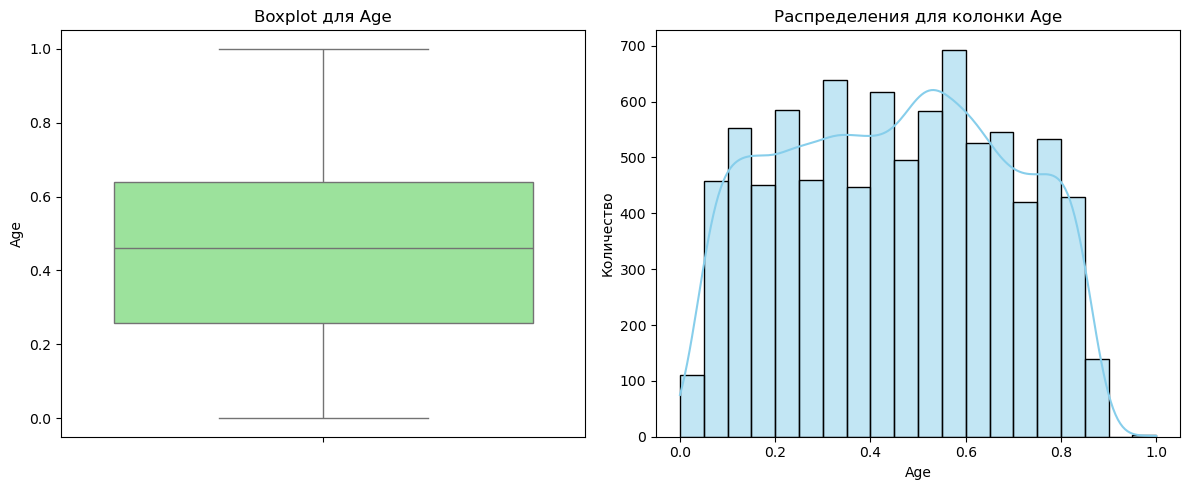

In [99]:
numerical(train_data['Age'],'Age')

count    966.000000
mean       0.452916
std        0.231068
min        0.044944
25%        0.247191
50%        0.460674
75%        0.640449
max        0.853933
Name: Age, dtype: float64

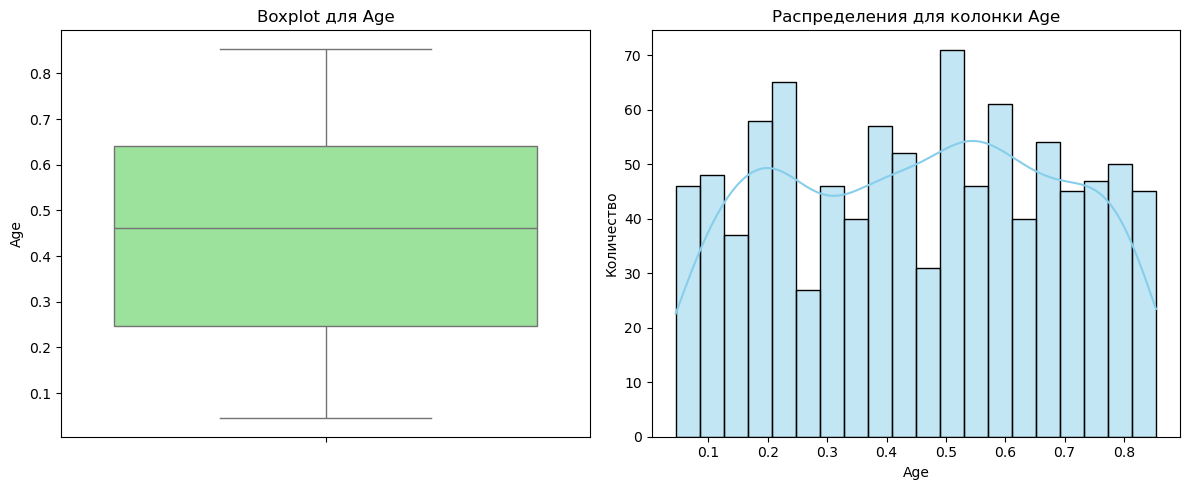

In [100]:
numerical(test_data['Age'],'Age')

**Cholesterol**

count    8685.000000
mean        0.501070
std         0.284716
min         0.000000
25%         0.267857
50%         0.499780
75%         0.746429
max         1.000000
Name: Cholesterol, dtype: float64

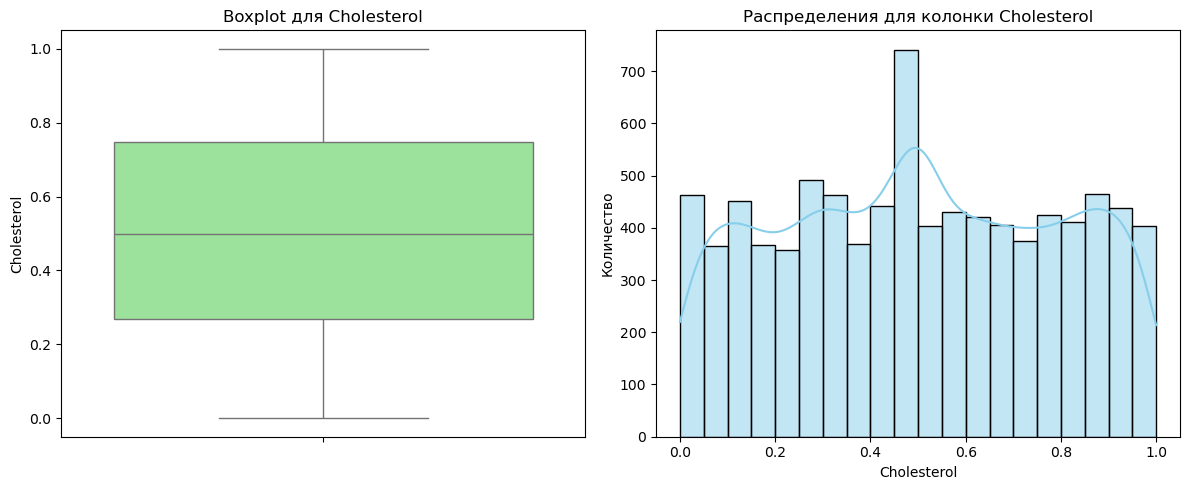

In [101]:
numerical(train_data['Cholesterol'],'Cholesterol')

count    966.000000
mean       0.488181
std        0.282039
min        0.000000
25%        0.243750
50%        0.499780
75%        0.710714
max        0.996429
Name: Cholesterol, dtype: float64

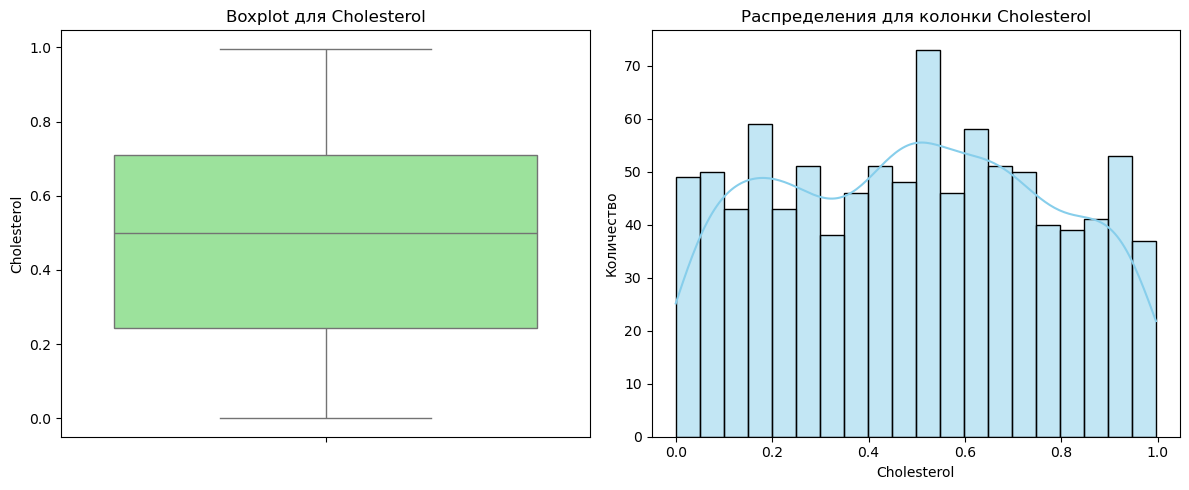

In [102]:
numerical(test_data['Cholesterol'],'Cholesterol')

**Heart rate**

count    8685.000000
mean        0.050658
std         0.023453
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         1.000000
Name: Heart rate, dtype: float64

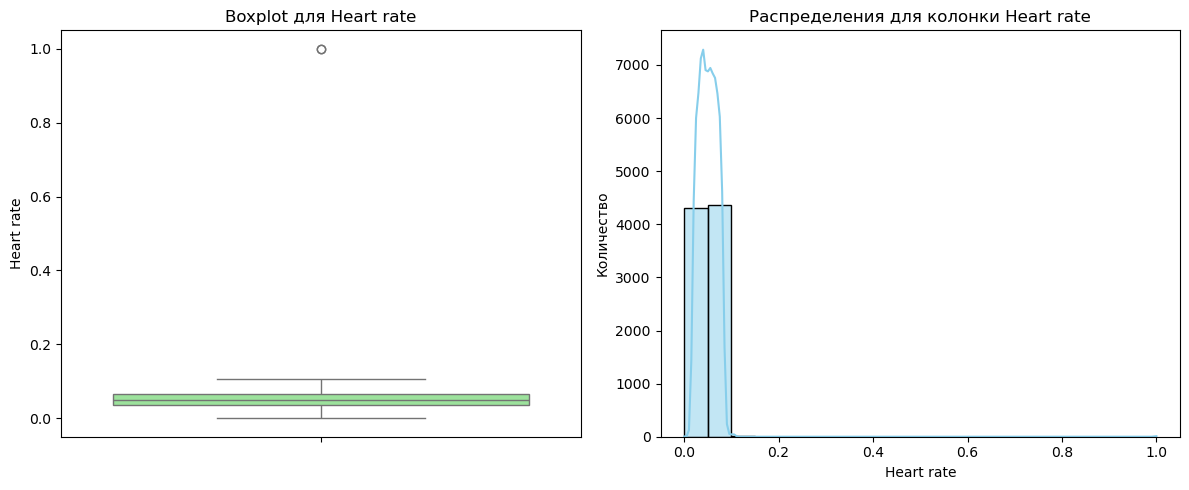

In [103]:
numerical(train_data['Heart rate'],'Heart rate')

Видим выброс на значений 1, когда остальные значения между 0.03-0.07

In [104]:
q_high = train_data['Heart rate'].quantile(0.99)
train_data = train_data[train_data['Heart rate'] <= q_high]

count    966.000000
mean       0.051644
std        0.035502
min        0.000000
25%        0.036664
50%        0.050412
75%        0.065995
max        1.000000
Name: Heart rate, dtype: float64

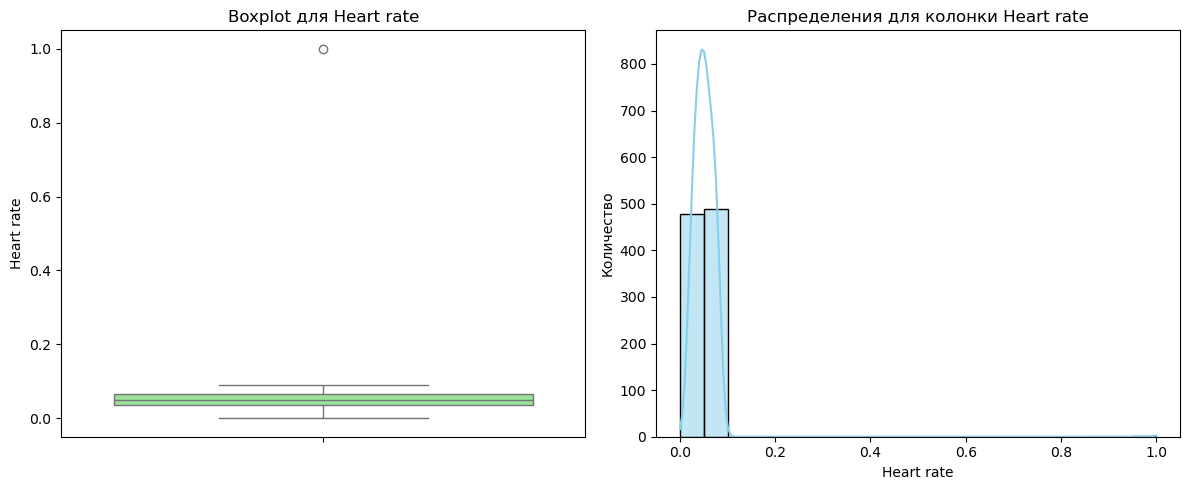

In [105]:
numerical(test_data['Heart rate'],'Heart rate')

In [106]:
q_high = test_data['Heart rate'].quantile(0.99)
test_data = test_data[test_data['Heart rate'] <= q_high]

**Smoking**

count    8644.000000
mean        0.905137
std         0.293043
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Smoking, dtype: float64

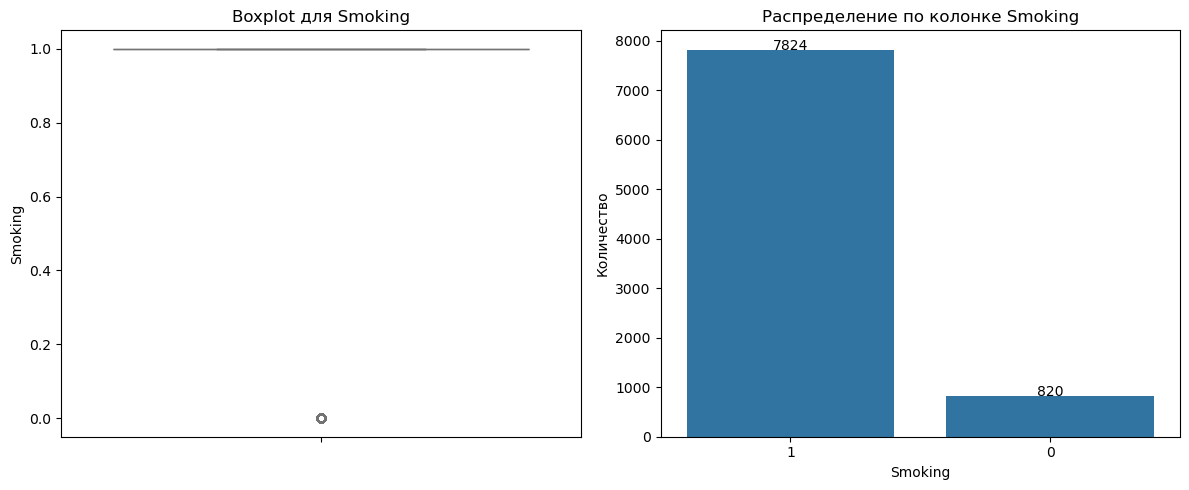

In [107]:
discrete(train_data['Smoking'],'Smoking')

Не будем удалять 820 строк данных, слишком много

count    961.000000
mean       0.901145
std        0.298623
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Smoking, dtype: float64

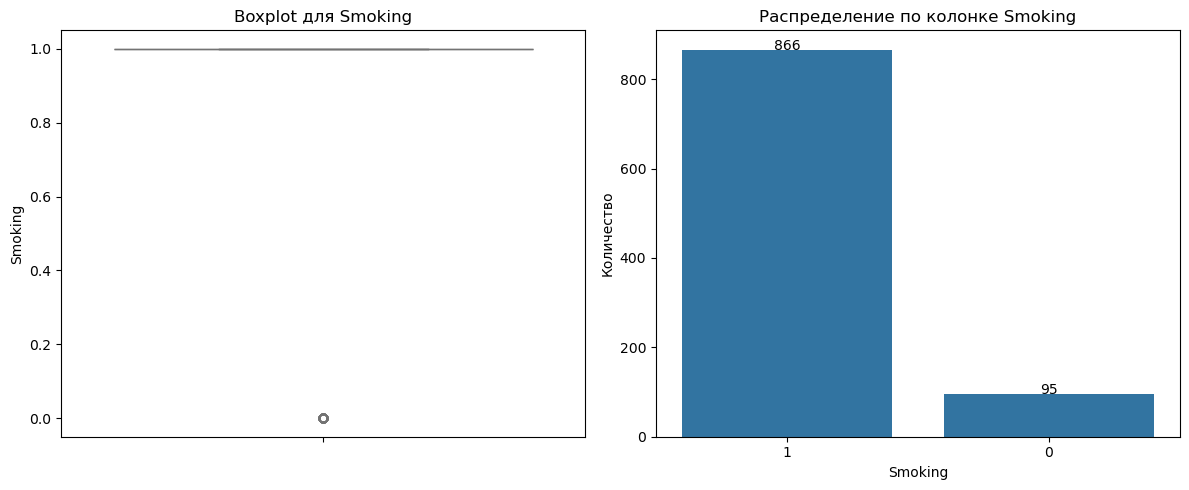

In [108]:
discrete(test_data['Smoking'],'Smoking')

**Exercise Hours Per Week**

count    8644.000000
mean        0.503384
std         0.285485
min         0.000000
25%         0.261852
50%         0.502110
75%         0.749619
max         1.000000
Name: Exercise Hours Per Week, dtype: float64

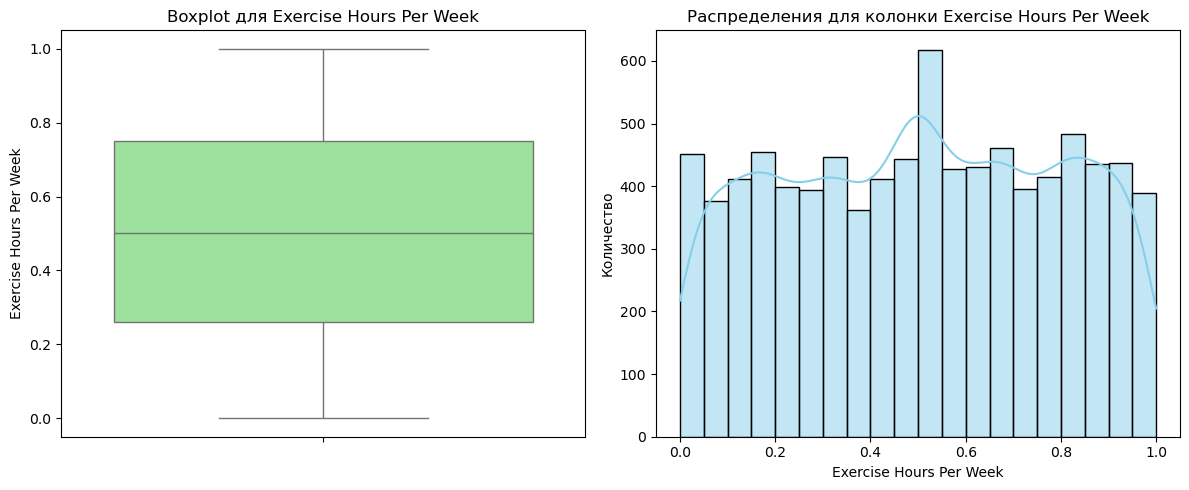

In [109]:
numerical(train_data['Exercise Hours Per Week'],'Exercise Hours Per Week')

count    961.000000
mean       0.490646
std        0.285642
min        0.000336
25%        0.242017
50%        0.502110
75%        0.735177
max        0.998938
Name: Exercise Hours Per Week, dtype: float64

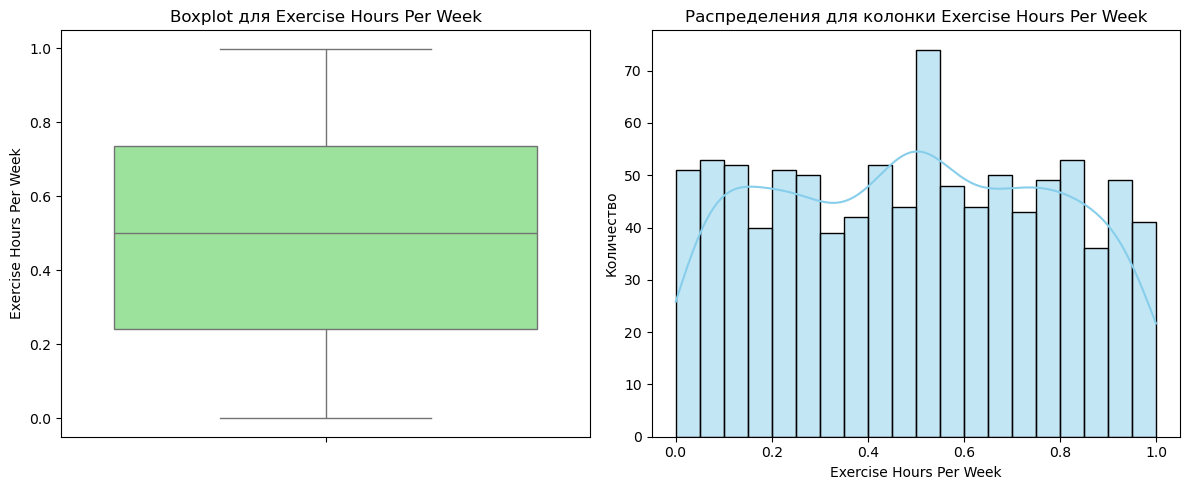

In [110]:
numerical(test_data['Exercise Hours Per Week'],'Exercise Hours Per Week')

**Diet**

In [111]:
train_data['Diet'].value_counts()

Diet
1    2863
2    2796
0    2783
3     202
Name: count, dtype: int64

In [112]:
#можно смело поменять тип данных на int64
train_data['Diet'] = train_data['Diet'].astype('int8')
test_data['Diet'] = test_data['Diet'].astype('int8')

count    8644.000000
mean        1.048242
std         0.858284
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Diet, dtype: float64

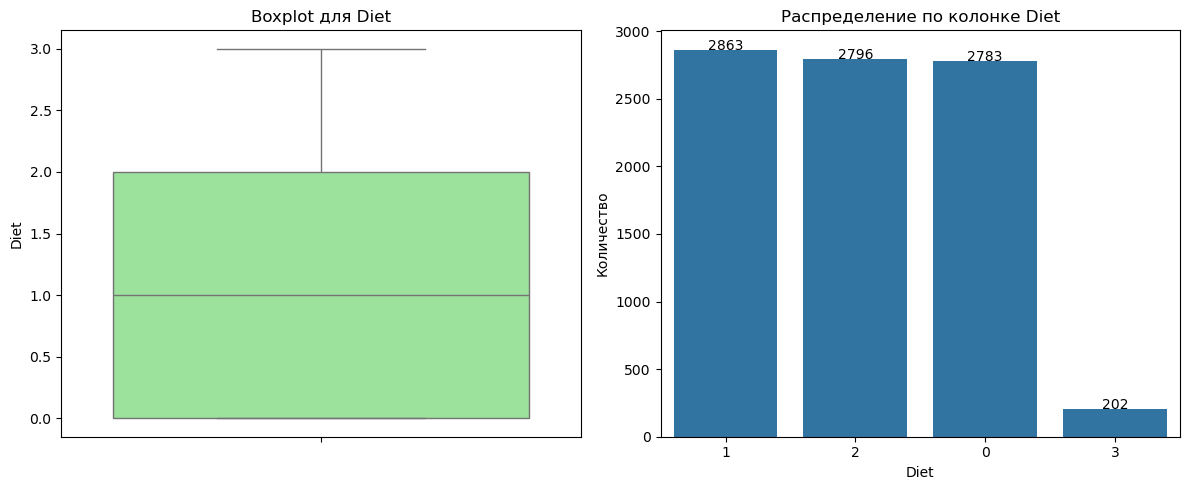

In [113]:
discrete(train_data['Diet'],'Diet')

count    961.000000
mean       1.043704
std        0.875693
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: Diet, dtype: float64

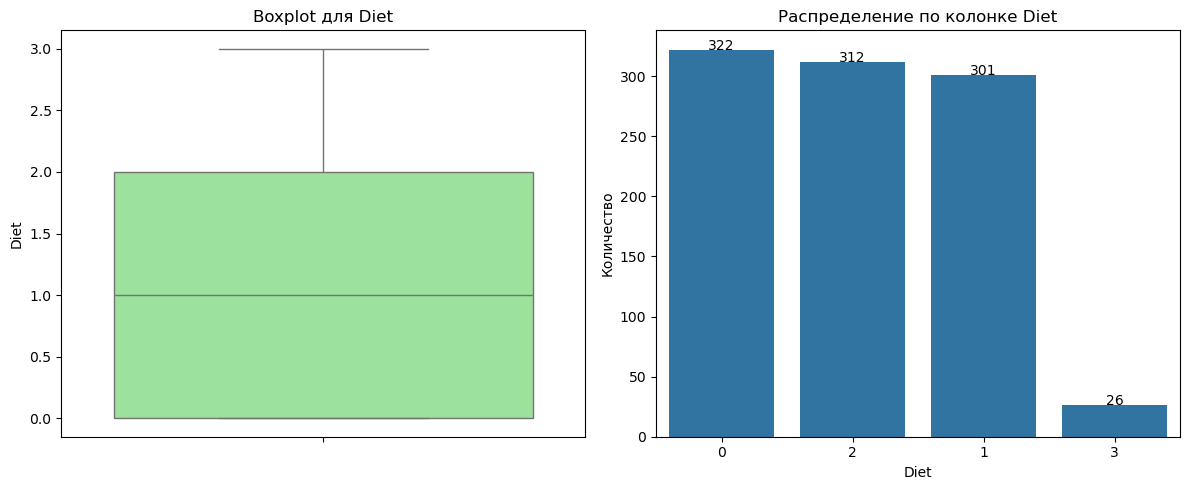

In [114]:
discrete(test_data['Diet'],'Diet')

**Stress Level**

count    8644.000000
mean        5.528575
std         2.843277
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: Stress Level, dtype: float64

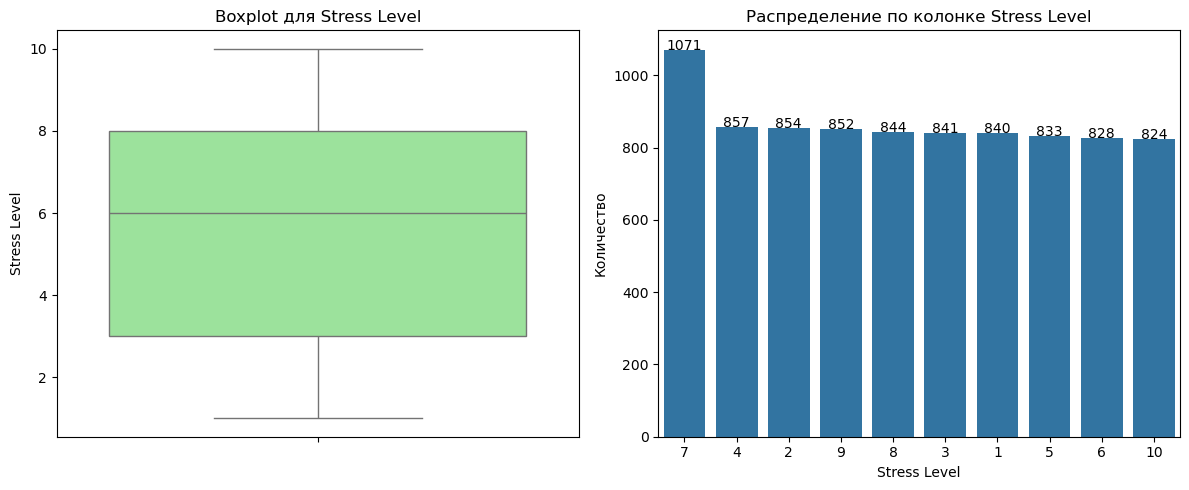

In [115]:
discrete(train_data['Stress Level'],'Stress Level')

count    961.000000
mean       5.377732
std        2.832454
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Stress Level, dtype: float64

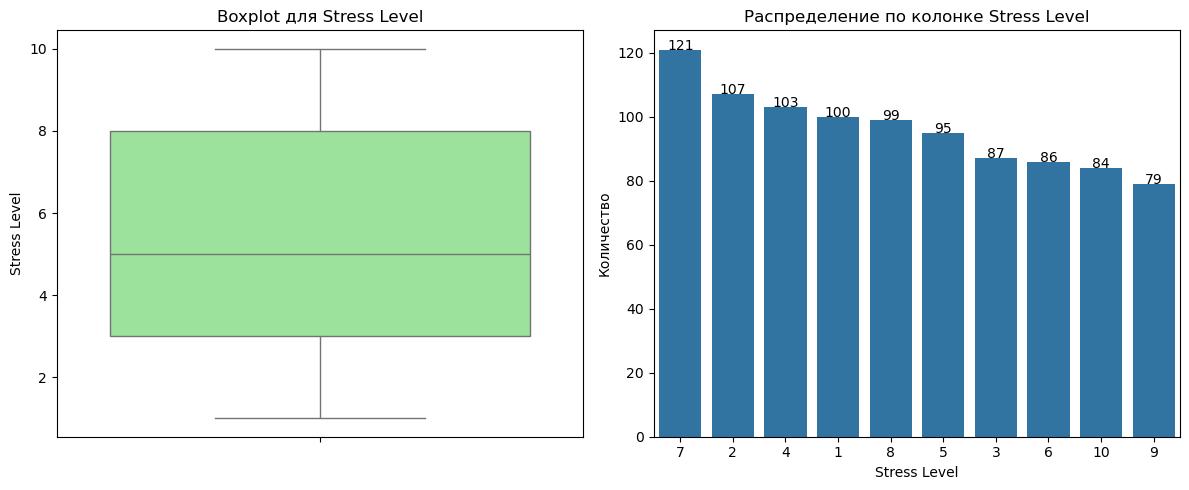

In [116]:
discrete(test_data['Stress Level'],'Stress Level')

**Sedentary Hours Per Day**

count    8644.000000
mean        0.499161
std         0.286016
min         0.000000
25%         0.254481
50%         0.499920
75%         0.745613
max         1.000000
Name: Sedentary Hours Per Day, dtype: float64

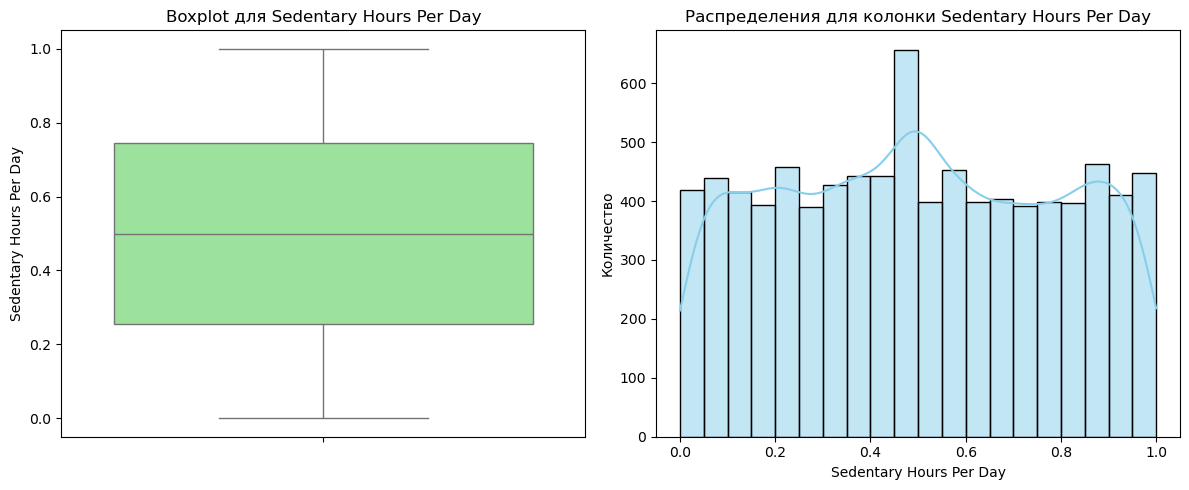

In [117]:
numerical(train_data['Sedentary Hours Per Day'],'Sedentary Hours Per Day')

count    961.000000
mean       0.506751
std        0.288574
min        0.001187
25%        0.256169
50%        0.502727
75%        0.762156
max        0.999033
Name: Sedentary Hours Per Day, dtype: float64

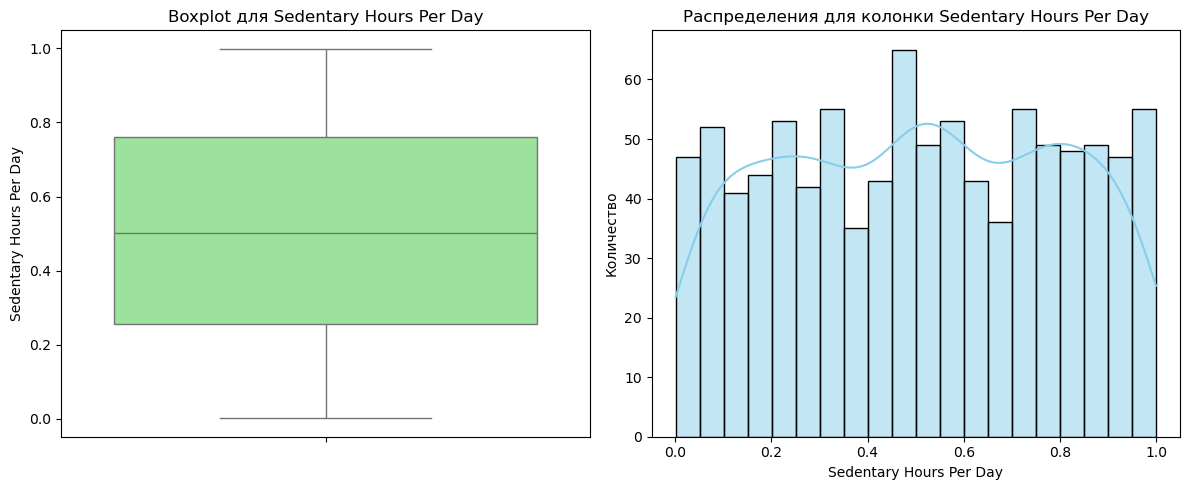

In [118]:
numerical(test_data['Sedentary Hours Per Day'],'Sedentary Hours Per Day')

**Income**

count    8644.000000
mean        0.496061
std         0.285372
min         0.000000
25%         0.250340
50%         0.494889
75%         0.742100
max         1.000000
Name: Income, dtype: float64

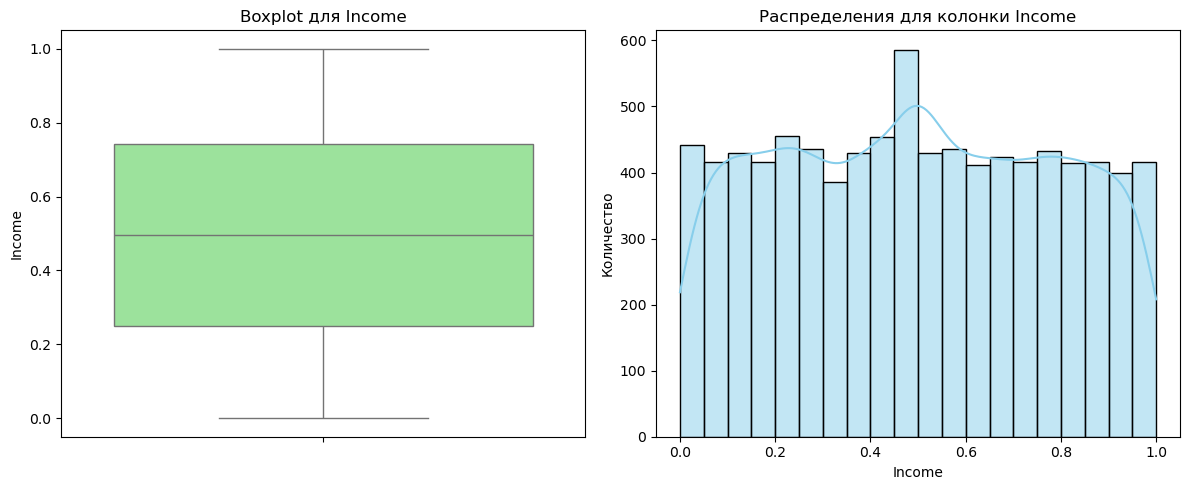

In [119]:
numerical(train_data['Income'],'Income')

count    961.000000
mean       0.484353
std        0.274590
min        0.003351
25%        0.259840
50%        0.489642
75%        0.710027
max        0.998885
Name: Income, dtype: float64

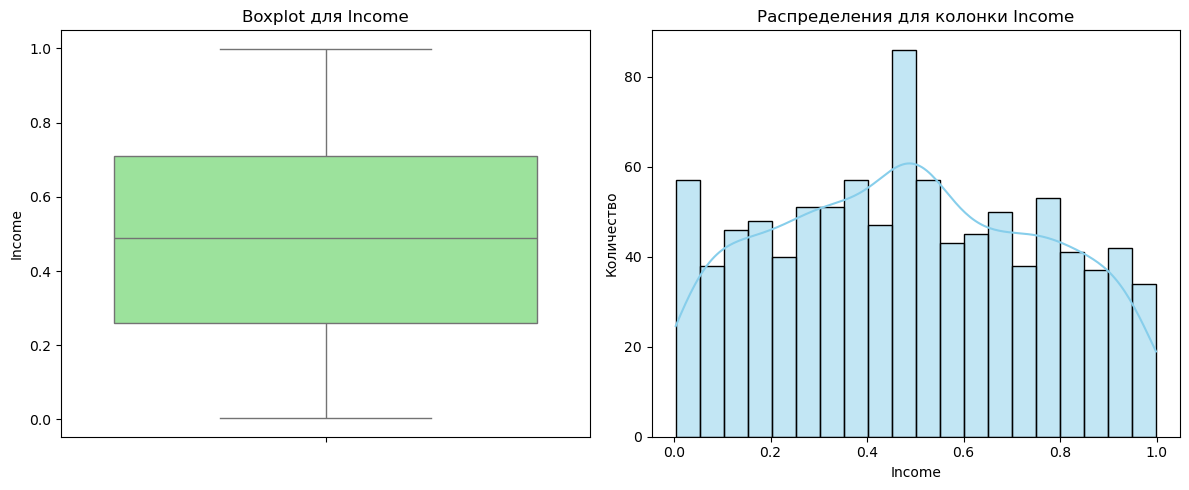

In [120]:
numerical(test_data['Income'],'Income')

**BMI**

count    8644.000000
mean        0.496783
std         0.283231
min         0.000000
25%         0.253403
50%         0.494774
75%         0.738609
max         1.000000
Name: BMI, dtype: float64

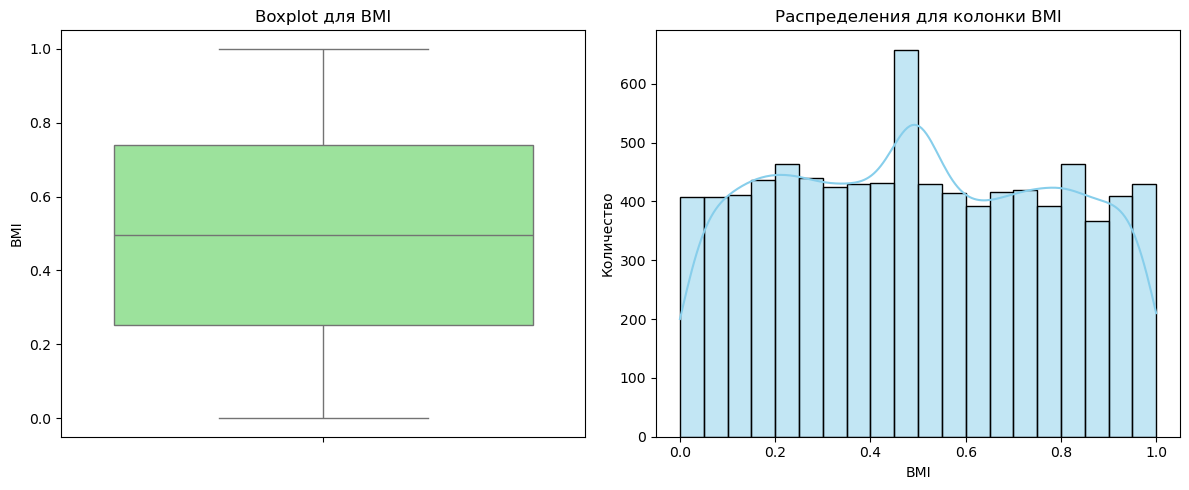

In [121]:
numerical(train_data['BMI'],'BMI')

count    961.000000
mean       0.476702
std        0.292744
min        0.002598
25%        0.217165
50%        0.469674
75%        0.723416
max        0.999496
Name: BMI, dtype: float64

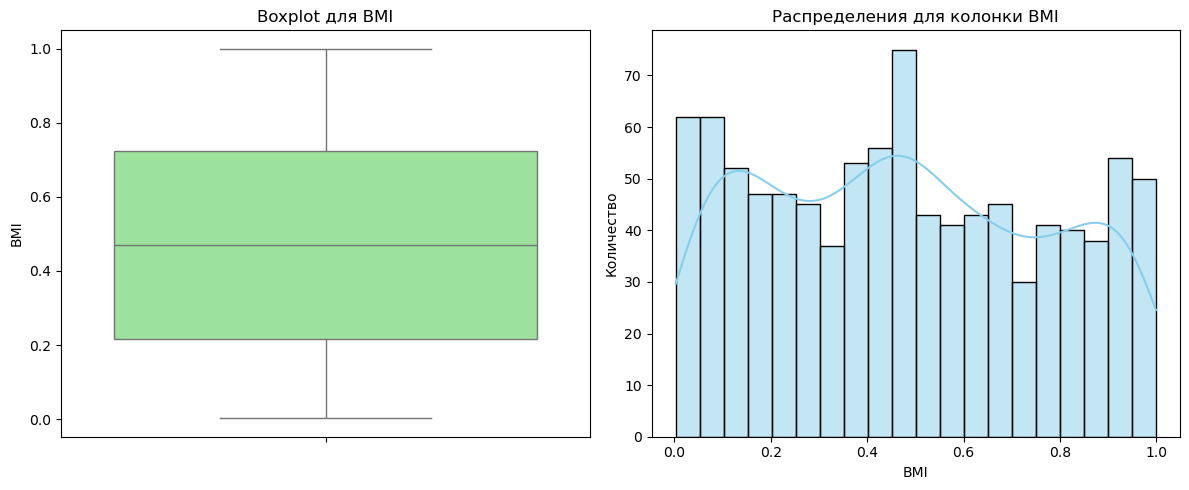

In [122]:
numerical(test_data['BMI'],'BMI')

**Triglycerides**

count    8644.000000
mean        0.505493
std         0.286998
min         0.000000
25%         0.262338
50%         0.503603
75%         0.751948
max         1.000000
Name: Triglycerides, dtype: float64

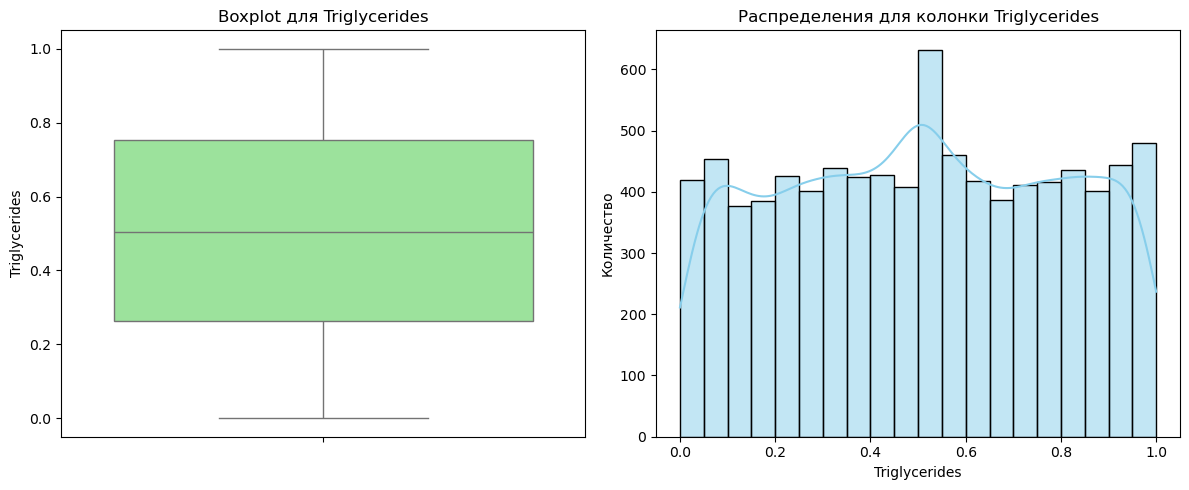

In [123]:
numerical(train_data['Triglycerides'],'Triglycerides')

count    961.000000
mean       0.486600
std        0.285271
min        0.000000
25%        0.249351
50%        0.487013
75%        0.722078
max        0.998701
Name: Triglycerides, dtype: float64

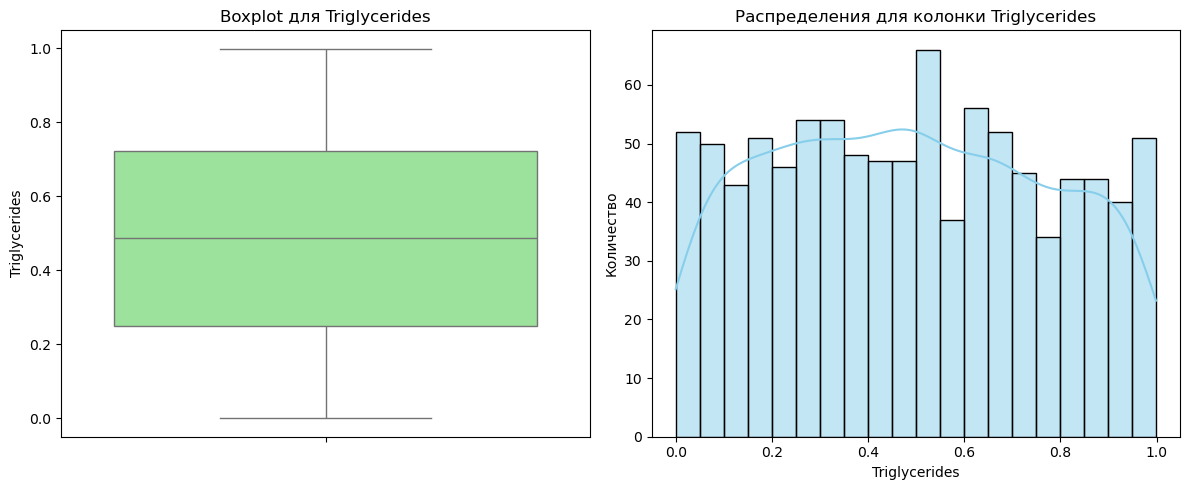

In [124]:
numerical(test_data['Triglycerides'],'Triglycerides')

**Physical Activity Days Per Week**

count    8644.000000
mean        3.496414
std         2.256257
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: Physical Activity Days Per Week, dtype: float64

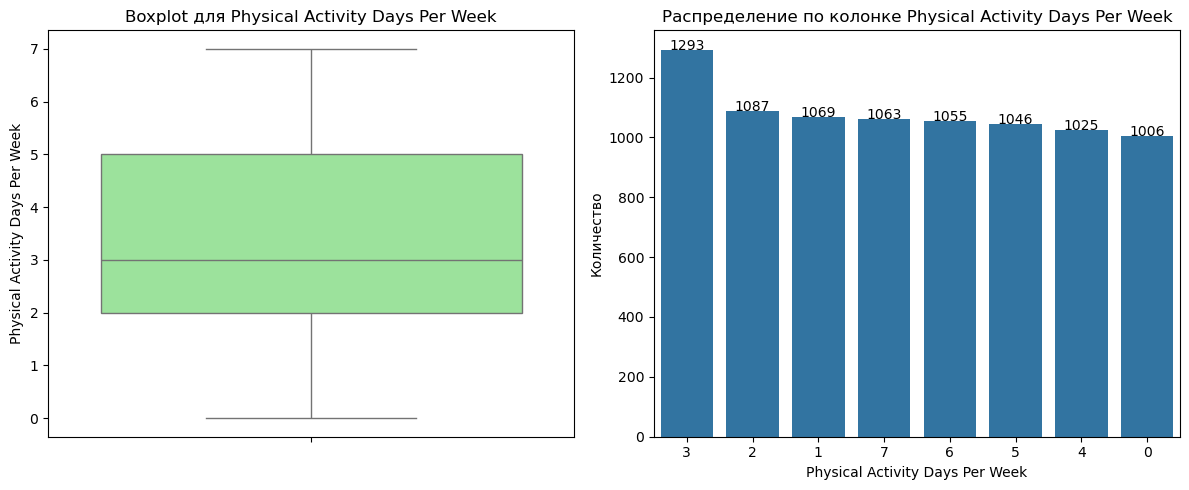

In [125]:
discrete(train_data['Physical Activity Days Per Week'],'Physical Activity Days Per Week')

count    961.000000
mean       3.431842
std        2.272523
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        7.000000
Name: Physical Activity Days Per Week, dtype: float64

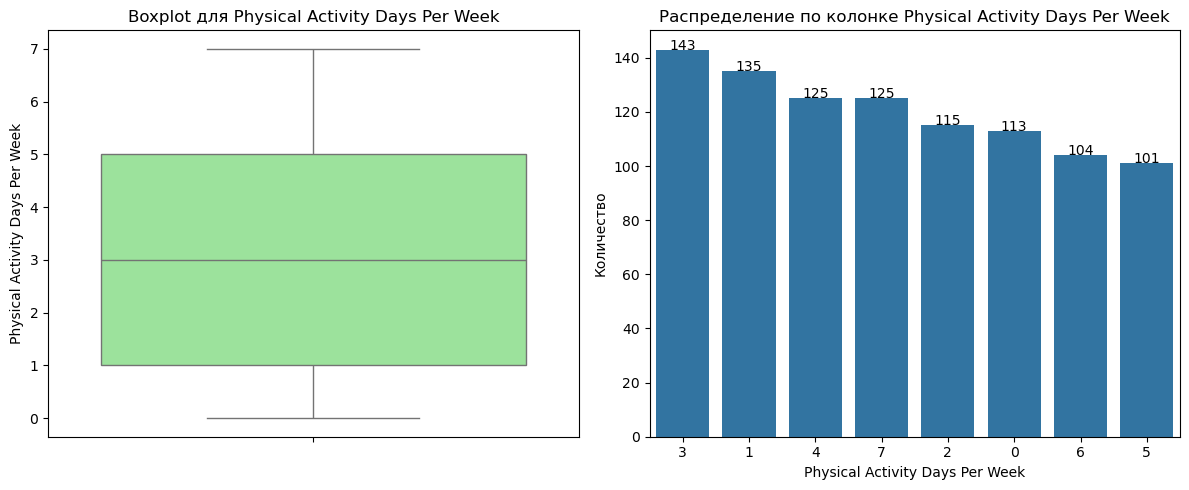

In [126]:
discrete(test_data['Physical Activity Days Per Week'],'Physical Activity Days Per Week')

**Sleep Hours Per Day**

In [127]:
train_data['Sleep Hours Per Day'].value_counts()

Sleep Hours Per Day
1.000000    1261
0.666667    1252
0.166667    1231
0.500000    1208
0.333333    1200
0.000000    1153
0.833333    1137
0.504621     202
Name: count, dtype: int64

count    8644.000000
mean        0.503733
std         0.328838
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: Sleep Hours Per Day, dtype: float64

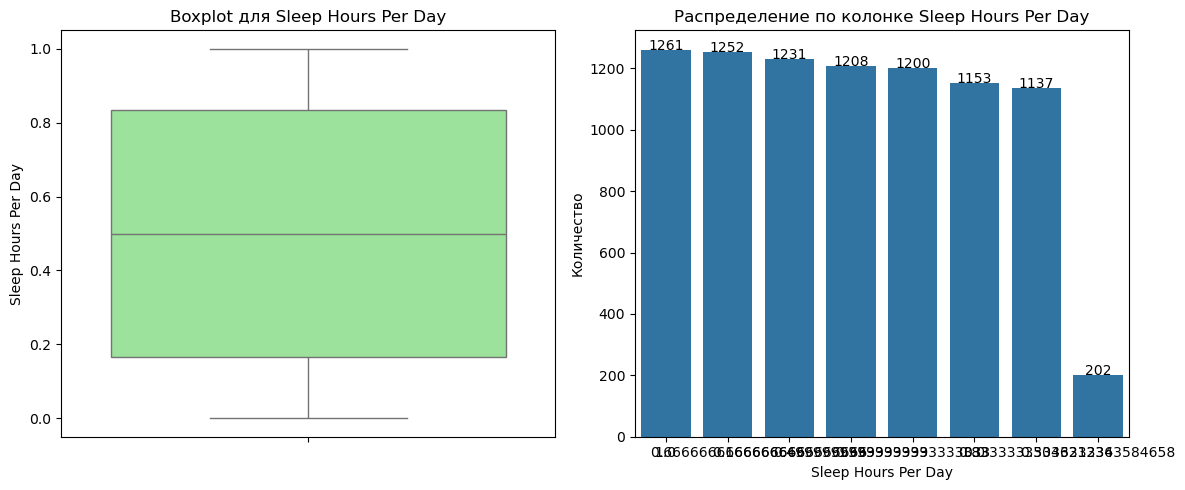

In [128]:
discrete(train_data['Sleep Hours Per Day'],'Sleep Hours Per Day')

count    961.000000
mean       0.512612
std        0.323130
min        0.000000
25%        0.166667
50%        0.500000
75%        0.833333
max        1.000000
Name: Sleep Hours Per Day, dtype: float64

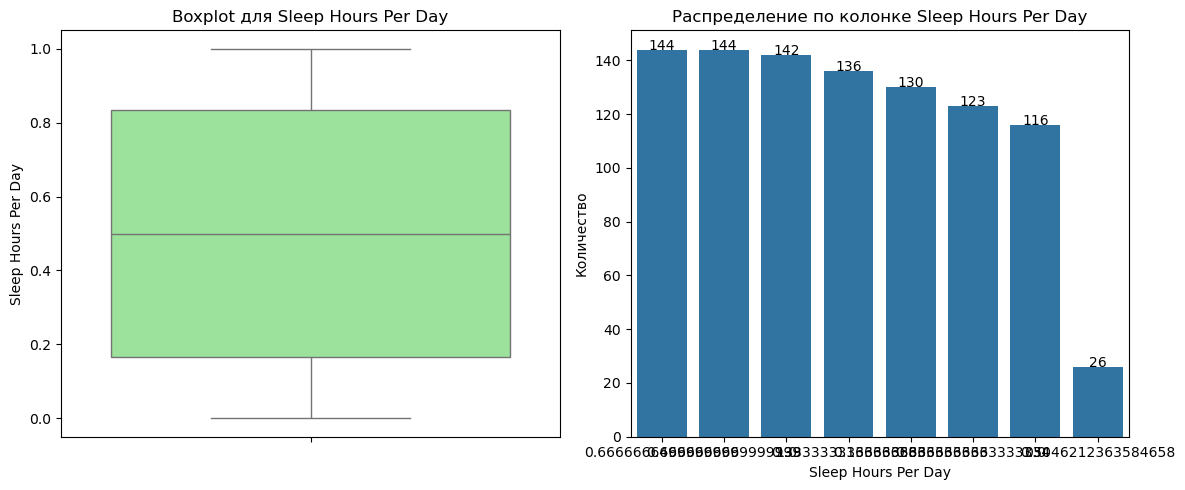

In [129]:
discrete(test_data['Sleep Hours Per Day'],'Sleep Hours Per Day')

**Blood sugar**

count    8644.000000
mean        0.227572
std         0.076584
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: Blood sugar, dtype: float64

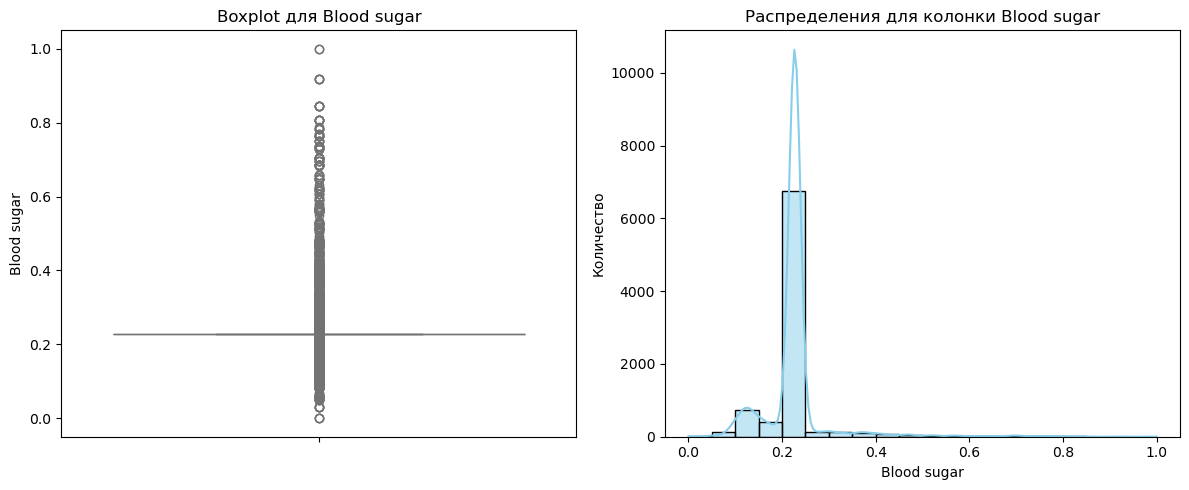

In [130]:
numerical(train_data['Blood sugar'],'Blood sugar')

Распределение сильно сосредоточено вогруг 0.3 - не будем избавляться от выбросов

count    961.000000
mean       0.224664
std        0.064962
min        0.029644
25%        0.227018
50%        0.227018
75%        0.227018
max        0.750988
Name: Blood sugar, dtype: float64

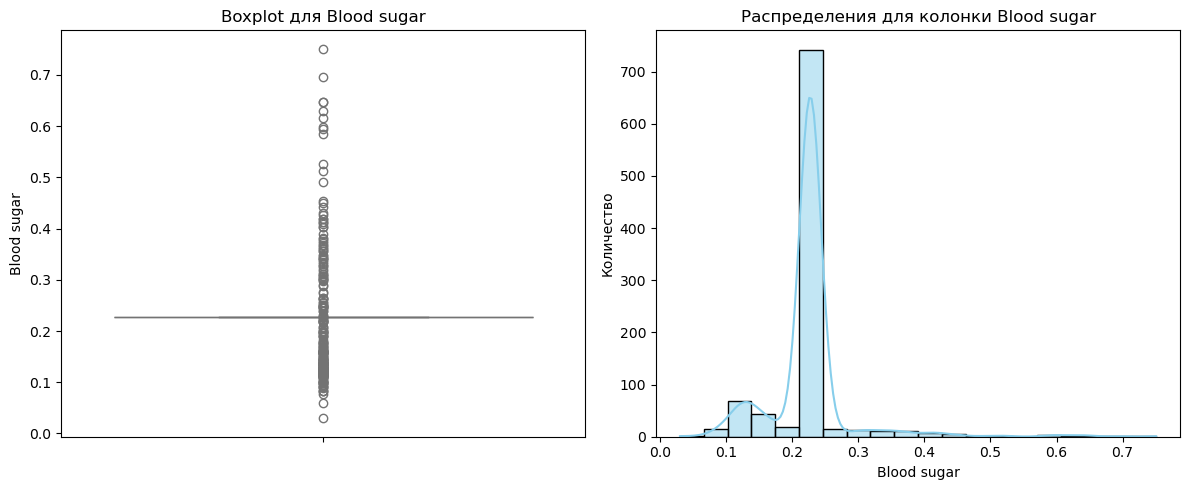

In [131]:
numerical(test_data['Blood sugar'],'Blood sugar')

**CK-MB**

count    8644.000000
mean        0.048153
std         0.075051
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: CK-MB, dtype: float64

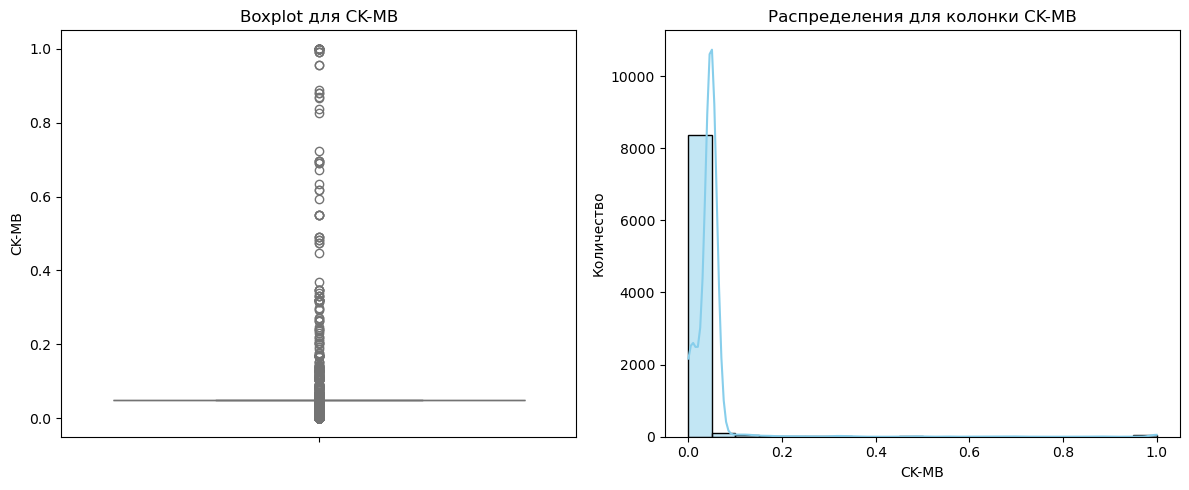

In [132]:
numerical(train_data['CK-MB'],'CK-MB')

count    961.000000
mean       0.048987
std        0.079913
min        0.000000
25%        0.048229
50%        0.048229
75%        0.048229
max        1.000000
Name: CK-MB, dtype: float64

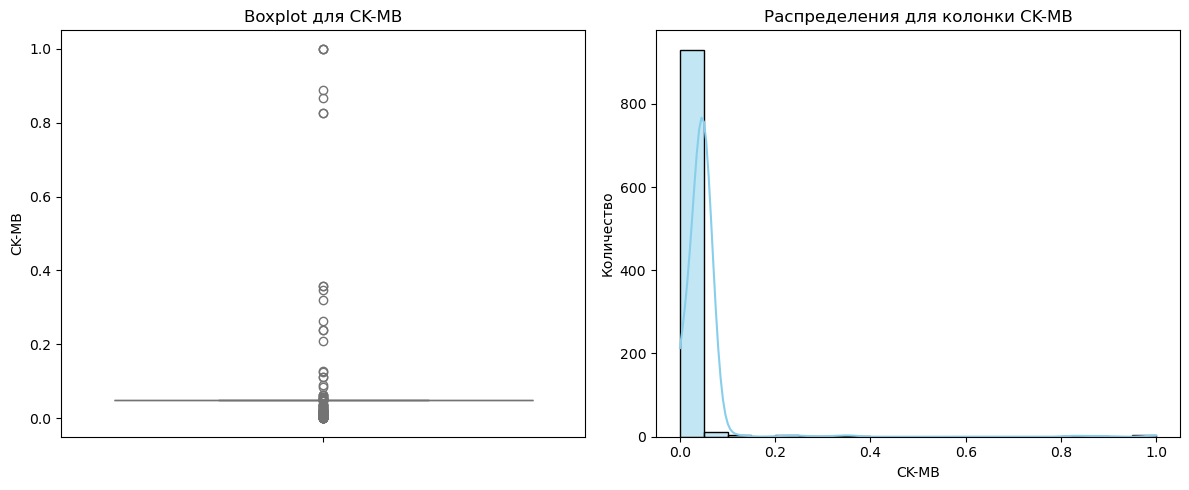

In [133]:
numerical(test_data['CK-MB'],'CK-MB')

**Troponin**

count    8644.000000
mean        0.036589
std         0.059262
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: Troponin, dtype: float64

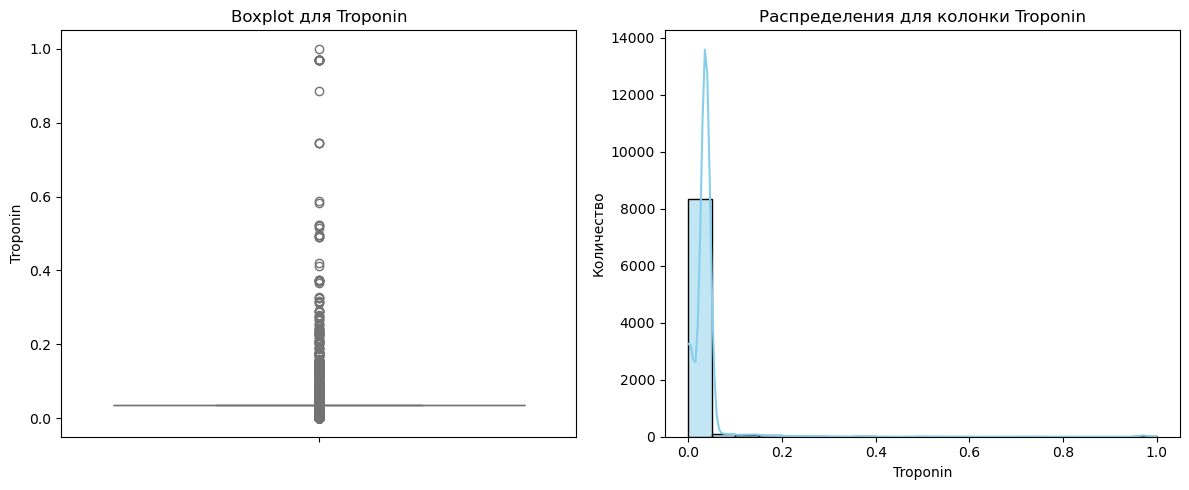

In [134]:
numerical(train_data['Troponin'],'Troponin')

count    961.000000
mean       0.034989
std        0.053918
min        0.000194
25%        0.036512
50%        0.036512
75%        0.036512
max        0.970871
Name: Troponin, dtype: float64

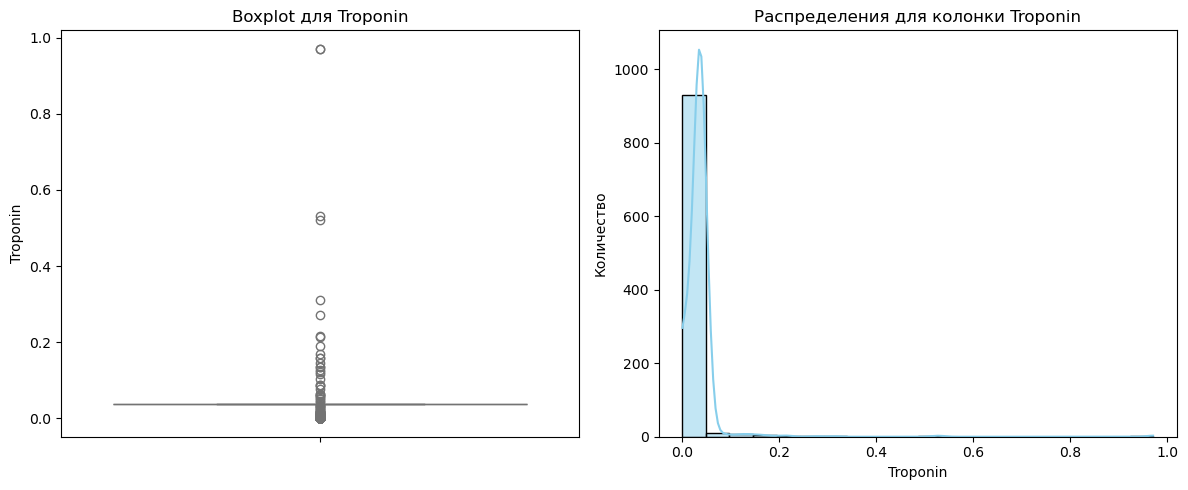

In [135]:
numerical(test_data['Troponin'],'Troponin')

**Systolic blood pressure**

count    8644.000000
mean        0.450546
std         0.170175
min         0.000000
25%         0.303226
50%         0.445161
75%         0.600000
max         0.961290
Name: Systolic blood pressure, dtype: float64

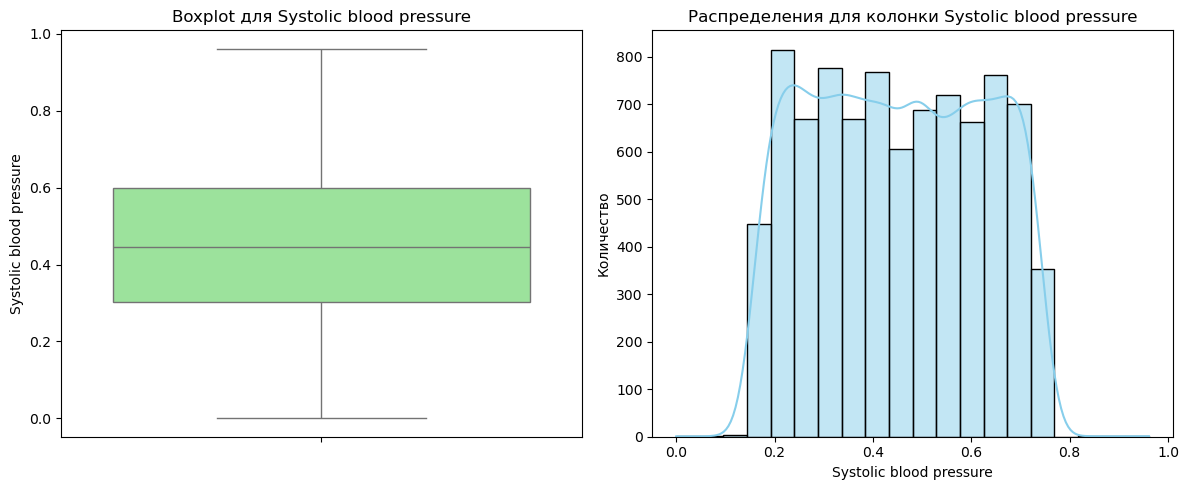

In [136]:
numerical(train_data['Systolic blood pressure'],'Systolic blood pressure')

count    961.000000
mean       0.447182
std        0.172013
min        0.012903
25%        0.296774
50%        0.445161
75%        0.600000
max        0.741935
Name: Systolic blood pressure, dtype: float64

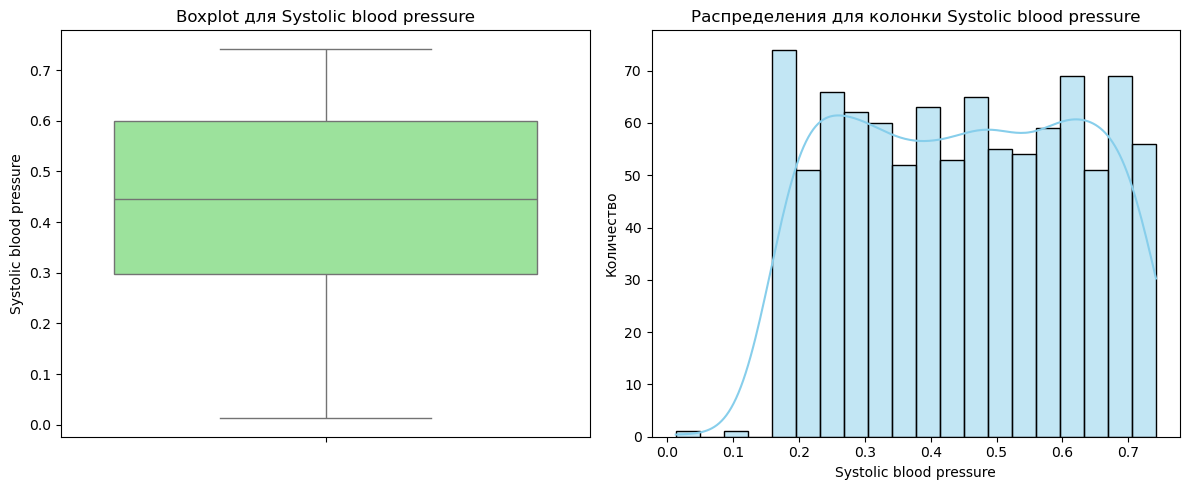

In [137]:
numerical(test_data['Systolic blood pressure'],'Systolic blood pressure')

**Diastolic blood pressure**

count    8644.000000
mean        0.498048
std         0.171677
min         0.000000
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: Diastolic blood pressure, dtype: float64

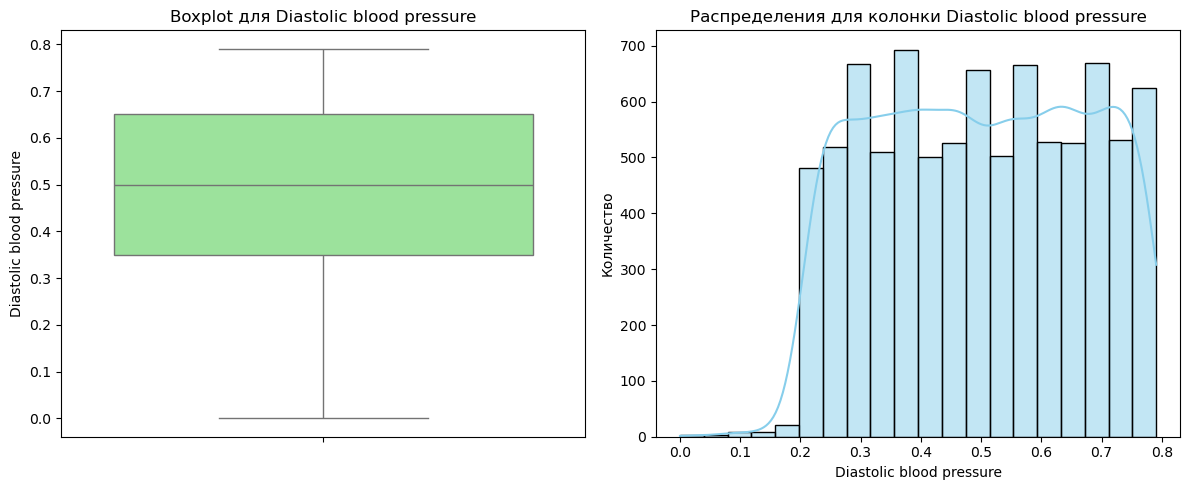

In [138]:
numerical(train_data['Diastolic blood pressure'],'Diastolic blood pressure')

count    961.000000
mean       0.496987
std        0.173890
min        0.116279
25%        0.348837
50%        0.488372
75%        0.639535
max        0.790698
Name: Diastolic blood pressure, dtype: float64

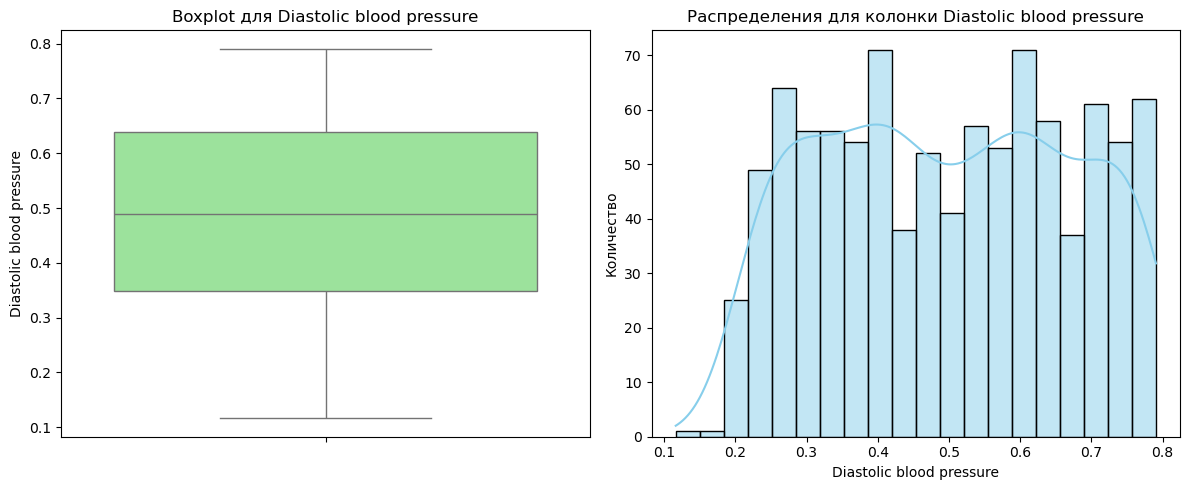

In [139]:
numerical(test_data['Diastolic blood pressure'],'Diastolic blood pressure')

### 3.2 Корреляционный и VIF анализ для train_data

In [140]:
target_col = train_data['Heart Attack Risk (Binary)']
train_data_id = train_data['id']
train_data = train_data.drop(['Heart Attack Risk (Binary)','id'],axis=1)
train_data.insert(0,'Heart Attack Risk (Binary)',target_col)


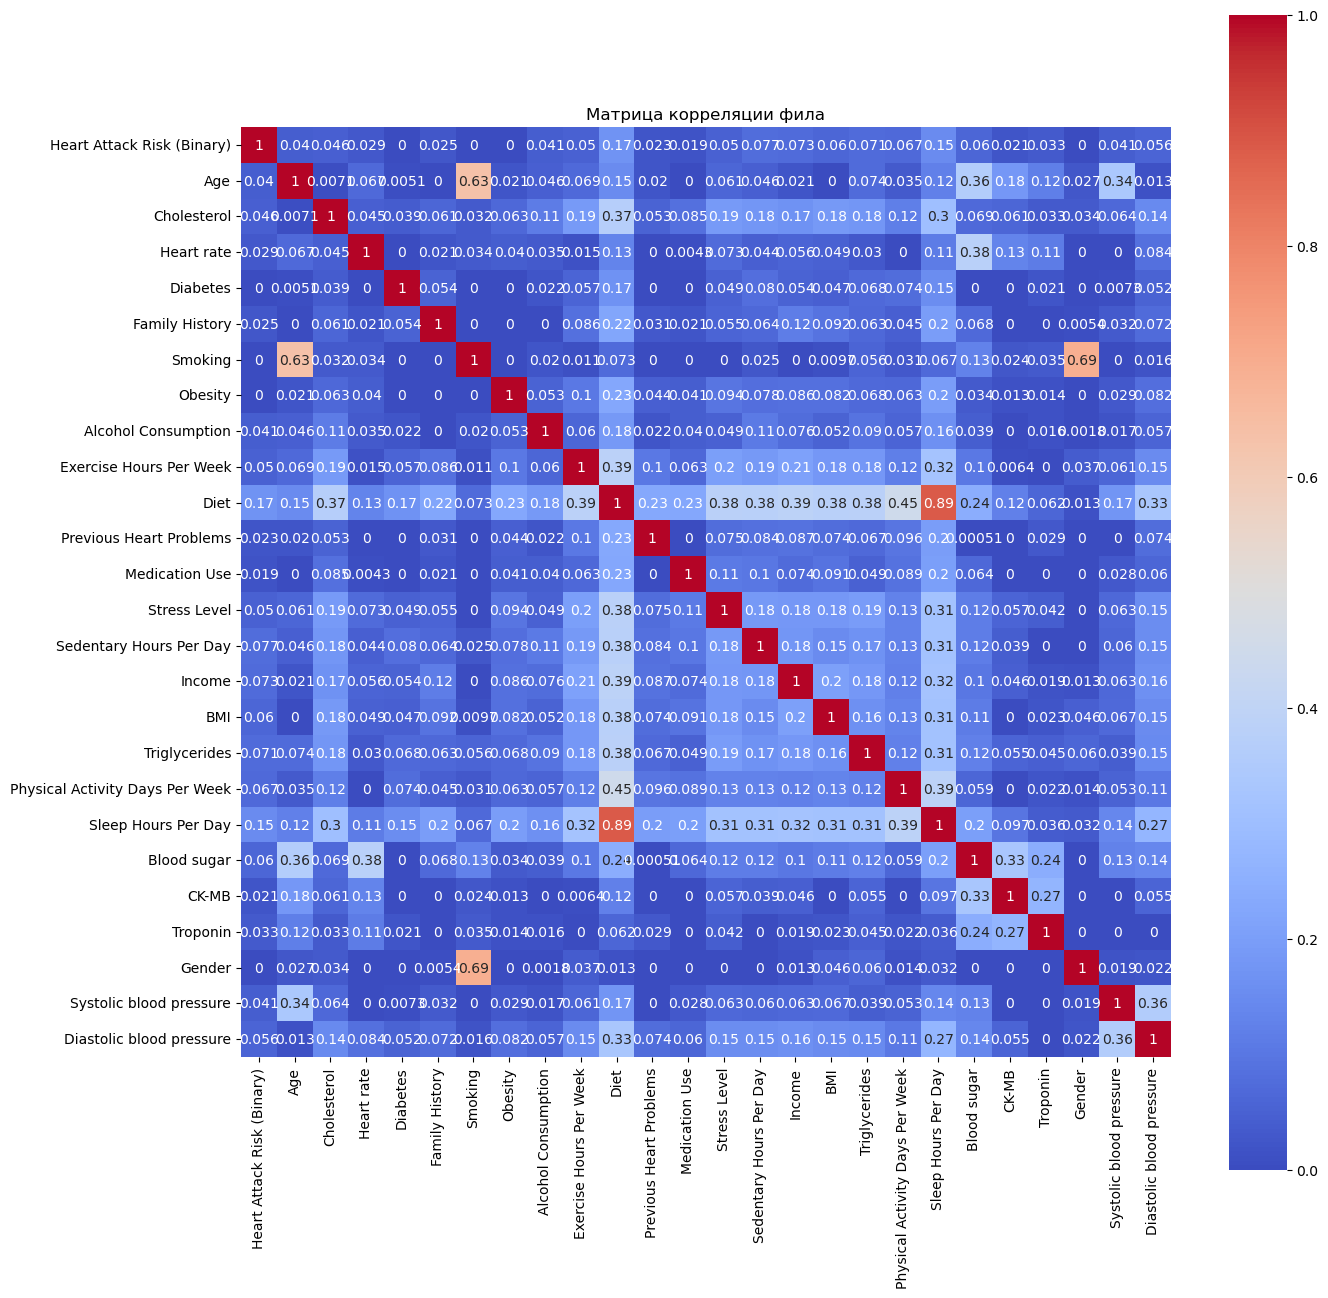

In [141]:
interval_cols = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Sleep Hours Per Day',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
]

phik_matrix = train_data.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(15,15))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, square=True)
plt.title('Матрица корреляции фила')
plt.show()

In [142]:
phik_matrix['Heart Attack Risk (Binary)'].sort_values(ascending=False)

Heart Attack Risk (Binary)         1.000000
Diet                               0.170776
Sleep Hours Per Day                0.150040
Sedentary Hours Per Day            0.076771
Income                             0.072757
Triglycerides                      0.070831
Physical Activity Days Per Week    0.066770
Blood sugar                        0.060436
BMI                                0.059658
Diastolic blood pressure           0.056447
Stress Level                       0.050319
Exercise Hours Per Week            0.050252
Cholesterol                        0.046011
Alcohol Consumption                0.040692
Systolic blood pressure            0.040573
Age                                0.040315
Troponin                           0.032652
Heart rate                         0.029105
Family History                     0.025333
Previous Heart Problems            0.023387
CK-MB                              0.020751
Medication Use                     0.019376
Smoking                         

Основные пары с сильной зависимостью (phik > 0.3)

- Smoking - Gender = 0.694  скорее один дублирует другой в части информации. **Скорее один признак уберу**
- Blood sugar - Heart rate = 0.376  сильная зависимость.
- Blood sugar - Age = 0.362  скорее сахар сильно растёт с возрастом.
- Systolic BP - Age = 0.340  стандартная физиология.
- Systolic BP - Diastolic BP = 0.358  давления связаны между собой. **Скорее один признак уберу или сделаю один признак**
- Diet - Sleep Hours Per Day = 0.887 очень высоко, будто кодированы схожим образом. **Скорее один признак уберу**

In [143]:
X_num = train_data.drop('Heart Attack Risk (Binary)',axis=1).copy()
X_num = pd.get_dummies(X_num, drop_first=True)

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]
print(vif_data.sort_values('VIF', ascending=False))

                            feature        VIF
5                           Smoking  16.352879
19                      Blood sugar   8.917851
24         Diastolic blood pressure   8.471204
2                        Heart rate   7.707899
23          Systolic blood pressure   7.399030
0                               Age   5.894468
12                     Stress Level   4.554261
22                           Gender   4.538003
8           Exercise Hours Per Week   3.959624
1                       Cholesterol   3.956384
16                    Triglycerides   3.949071
15                              BMI   3.942867
13          Sedentary Hours Per Day   3.938076
14                           Income   3.880180
17  Physical Activity Days Per Week   3.329580
18              Sleep Hours Per Day   3.259823
3                          Diabetes   2.881754
7               Alcohol Consumption   2.533397
9                              Diet   2.483546
11                   Medication Use   2.040526
6            

- VIF = 1 - нет мультиколлинеарности
- VIF > 5 - есть зависимость
- VIF > 10 - высокая мультиколлинеарность

Очень высокий VIF:

- Smoking - 16.35
- Blood sugar - 8.92
- Diastolic blood pressure - 8.47
- Heart rate - 7.70
- Systolic blood pressure - 7.40

Средний VIF(5–6):
- Age - 5.89

Остальные в норме (<=5).

## 4. Подготовка данных

In [144]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8644 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Heart Attack Risk (Binary)       8644 non-null   int8   
 1   Age                              8644 non-null   float64
 2   Cholesterol                      8644 non-null   float64
 3   Heart rate                       8644 non-null   float64
 4   Diabetes                         8644 non-null   int8   
 5   Family History                   8644 non-null   int8   
 6   Smoking                          8644 non-null   int8   
 7   Obesity                          8644 non-null   int8   
 8   Alcohol Consumption              8644 non-null   int8   
 9   Exercise Hours Per Week          8644 non-null   float64
 10  Diet                             8644 non-null   int8   
 11  Previous Heart Problems          8644 non-null   int8   
 12  Medication Use           

In [145]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              961 non-null    float64
 1   Cholesterol                      961 non-null    float64
 2   Heart rate                       961 non-null    float64
 3   Diabetes                         961 non-null    int8   
 4   Family History                   961 non-null    int8   
 5   Smoking                          961 non-null    int8   
 6   Obesity                          961 non-null    int8   
 7   Alcohol Consumption              961 non-null    int8   
 8   Exercise Hours Per Week          961 non-null    float64
 9   Diet                             961 non-null    int8   
 10  Previous Heart Problems          961 non-null    int8   
 11  Medication Use                   961 non-null    int8   
 12  Stress Level               

In [146]:
num_cols = [
    'Age', 
    'Cholesterol', 
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    # 'Sleep Hours Per Day',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    # 'Systolic blood pressure',
    'Diastolic blood pressure'
]

cat_cols = [
    'Diabetes',
    'Family History',
    # 'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Stress Level',
    'Physical Activity Days Per Week',
    'Gender'
]

In [147]:
# Smoking - Gender = 0.694 скорее один дублирует другой в части информации. Скорее один признак уберу
# Blood sugar - Heart rate = 0.376 сильная зависимость.
# Blood sugar - Age = 0.362 скорее сахар сильно растёт с возрастом.
# Systolic BP - Age = 0.340 стандартная физиология.
# Systolic BP - Diastolic BP = 0.358 давления связаны между собой. Скорее один признак уберу или сделаю один признак
# Diet - Sleep Hours Per Day = 0.887 очень высоко, будто кодированы схожим образом. Скорее один признак уберу

In [148]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X = train_data.drop(['Heart Attack Risk (Binary)','Sleep Hours Per Day','Smoking','Systolic blood pressure'],axis=1)
y = train_data['Heart Attack Risk (Binary)']

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_test = test_data.drop(['id','Sleep Hours Per Day','Smoking','Systolic blood pressure'],axis=1)
test_data_id = test_data['id']

num_transformer = Pipeline(steps=[('scaler', 'passthrough')])
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_transformer,num_cols),
        ('cat',cat_transformer,cat_cols)
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('models',LogisticRegression())
])

## 5. Обучение модели

In [149]:
param_distributions = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(1, min(6, X_train.shape[1]) + 1),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

In [150]:
randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 6), 'models__max_features': range(1, 7), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(2, 5), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [151]:
print('Лучшая модель и ее параметры: ', randomized_search.best_estimator_)

Лучшая модель и ее параметры:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Cholesterol',
                                                   'Heart rate',
                                                   'Exercise Hours Per Week',
                                                   'Sedentary Hours Per Day',
                                                   'Income', 'BMI',
                                                   'Triglycerides',
                                                   'Blood sugar', 'CK-MB',
                                                   'Troponin',
                                                   'Diastolic blood pressure']),
                                                 ('cat', 'passthrou

In [152]:
# # вероятности для класса "1" на валидации
# y_proba_val = randomized_search.best_estimator_.predict_proba(X_valid)[:,1]

# # получаем значения precision, recall и thresholds
# precision, recall, thresholds = precision_recall_curve(y_valid, y_proba_val)

# # считаем F1 для каждого порога
# f1_scores = 2 * (precision*recall) / (precision + recall + 1e-8)

# # находим лучший порог
# best_idx = np.argmax(f1_scores)
# best_threshold = thresholds[best_idx]
# best_f1 = f1_scores[best_idx]

# print(f"Лучший порог: {best_threshold:.2f}")
# print(f"F1-score: {best_f1:.4f}")
# print(f"Precision: {precision[best_idx]:.4f}")
# print(f"Recall: {recall[best_idx]:.4f}")

# # строим график Precision-Recall
# plt.figure(figsize=(7,5))
# plt.plot(recall, precision, label="Precision-Recall curve")
# plt.scatter(recall[best_idx], precision[best_idx], color="red", 
#             label=f"Лучший порог={best_threshold:.2f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve (Validation)")
# plt.legend()
# plt.grid()
# plt.show()

F1-score: 0.4750
ROC-AUC: 0.5619
Recall при пороге 0.2: 0.6293
Precision при пороге 0.2: 0.3814


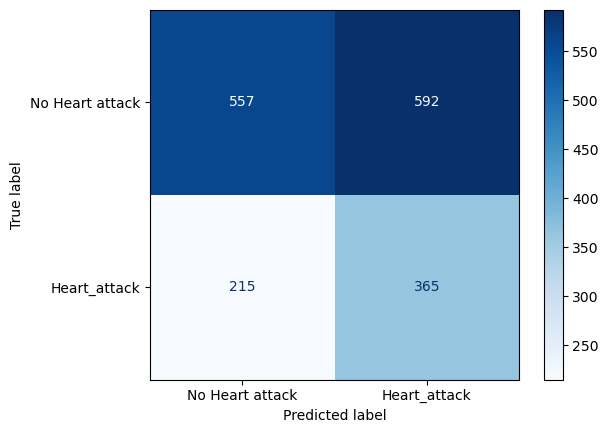

In [153]:
y_proba_val = randomized_search.best_estimator_.predict_proba(X_valid)[:,1]

threshold = 0.2
y_pred_val = (y_proba_val >= threshold).astype(int)

#f1_score
f1 = f1_score(y_valid,y_pred_val)
print(f"F1-score: {f1:.4f}")

#roc_auc_score
roc_auc = roc_auc_score(y_valid, y_proba_val)
print(f"ROC-AUC: {roc_auc:.4f}")

#recall
recall_val= recall_score(y_valid,y_pred_val)
print(f"Recall при пороге {threshold}: {recall_val:.4f}")

#precision score
precision_val = precision_score(y_valid,y_pred_val)
print(f"Precision при пороге {threshold}: {precision_val:.4f}")

#confusion matrix
cm = confusion_matrix(y_valid,y_pred_val, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Heart attack','Heart_attack'])
disp.plot(cmap='Blues')
plt.show()

In [154]:
cm

array([[557, 592],
       [215, 365]])

In [155]:
# y_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

# y_pred = (y_pred_proba >= threshold).astype(int)

# final_df = pd.DataFrame({
#     'id':test_data_id,
#     'prediction':y_pred
# })

# final_df.to_csv('predicted.csv',index=False)

In [156]:
#сохраняю свою модель
model = randomized_search.best_estimator_
joblib.dump(model,'model.pkl')

['model.pkl']

## Выводы

**Предобработка данных**

    - Привели данные в нужных колонках к корректному типу и заполнили пропуски модами.
    - В признаке Heart rate удалили выбросы.

**Корреляционный и VIF-анализ**
- Основные пары с сильной зависимостью (phik > 0.3):
    - Smoking – Gender = 0.694 → скорее один дублирует другой. Убрали Smoking из признаков.
    - Blood sugar – Heart rate = 0.376 → взаимосвязь уровня сахара и пульса.
    - Blood sugar – Age = 0.362 → сахар растёт с возрастом.
    - Systolic BP – Age = 0.340 → стандартная физиология.
    - Systolic BP – Diastolic BP = 0.358 → давления связаны. Убрали Systolic BP из признаков.
    - Diet – Sleep Hours Per Day = 0.887 → признаки кодированы схожим образом. Убрали Sleep Hours Per Day.
- Очень высокий VIF:
    - Smoking – 16.35
    - Blood sugar – 8.92
    - Diastolic BP – 8.47
    - Heart rate – 7.70
    - Systolic BP – 7.40
- Средний уровень мультиколлинеарности (VIF ~5–6):
    - Age – 5.89

Остальные признаки были оставлены.

**Подбор моделей**

- Использовали Pipeline + RandomizedSearchCV.
- В пайплайн входили:
    - предобработка данных: масштабирование числовых признаков (StandardScaler, MinMaxScaler, либо passthrough);
    - классификаторы:
        - DecisionTreeClassifier,
        - KNeighborsClassifier,
        - LogisticRegression,
        - SVC.

- Подбирались ключевые гиперпараметры для каждой модели:
    - Decision Tree: max_depth, max_features, масштабирование;
    - KNN: n_neighbors, масштабирование;
    - Logistic Regression: коэффициент регуляризации C, масштабирование;
    - SVC: параметр C, масштабирование.

- Лучшая модель: **KNeighborsClassifier** (n_neighbors=2) с предобработкой числовых признаков через MinMaxScaler.
- Качество модели
    - F1-score: 0.4750
    - ROC-AUC: 0.5619
    - Recall при пороге 0.2: 0.6293
    - Precision при пороге 0.2: 0.3814

**Итог**
- Модель показала среднее качество предсказаний.
- ROC-AUC = 0.56 говорит о том, что модель лишь немного лучше случайного угадывания (0.5).
- При низком пороге (0.2) удалось повысить полноту (Recall ~0.63), но за счёт снижения точности (Precision ~0.38).
- F1-score (~0.47) также указывает на дисбаланс между Precision и Recall.